# Импорт библиотек, загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.semi_supervised import SelfTrainingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import classification_report

import gensim
import gensim.downloader as api

In [ ]:
train_set = pd.read_csv('/content/drive/MyDrive/BIV Hack данные/payments_training.tsv',
                        delimiter='\t',
                        header=None)
train_set.columns = ['id', 'date', 'price', 'text', 'target']
train_set

,id,date,price,text,target
0,1,07.11.2024,15300.00,За участие в конференции в г. Майкоп по догово...,SERVICE
1,2,07.11.2024,"40200,00",За оказание услуг по договору №79-02726В от 01...,SERVICE
2,3,07.11.2024,1440-00,Оплата за Порошок стиральный Ariel Color autom...,NON_FOOD_GOODS
3,4,07.11.2024,240000000-00,Возврат денежных средств по договору займа №04...,LOAN
4,5,07.11.2024,1360000.00,"Оплата Дог №452 от 13/03/2021, согл. Сч 0745-2...",NOT_CLASSIFIED
...,...,...,...,...,...
495,496,07.11.2024,2610.00,Оплата налогов,TAX
496,497,07.11.2024,31200-00,Комиссия за выполнение функций агента валютног...,BANK_SERVICE
497,498,07.11.2024,18200-00,За тур.поездку по договору №75-04243Г от 24/04...,SERVICE
498,499,07.11.2024,"2870000,00","Оплата по договору №095 от 24.02.2025г, счету ...",FOOD_GOODS


In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      500 non-null    int64 
 1   date    500 non-null    object
 2   price   500 non-null    object
 3   text    500 non-null    object
 4   target  500 non-null    object
dtypes: int64(1), object(4)
memory usage: 19.7+ KB


In [ ]:
pd.DataFrame(train_set.groupby('target')['date'].value_counts())

,,count
target,date,
BANK_SERVICE,07.11.2024,49
FOOD_GOODS,07.11.2024,90
LEASING,07.11.2024,38
LOAN,07.11.2024,41
NON_FOOD_GOODS,07.11.2024,96
NOT_CLASSIFIED,07.11.2024,23
REALE_STATE,07.11.2024,27
SERVICE,07.11.2024,88
TAX,07.11.2024,48


In [ ]:
trg_encoder = LabelEncoder()
train_set['target'] = trg_encoder.fit_transform(train_set['target'])
train_set

,id,date,price,text,target
0,1,07.11.2024,15300.00,За участие в конференции в г. Майкоп по догово...,7
1,2,07.11.2024,"40200,00",За оказание услуг по договору №79-02726В от 01...,7
2,3,07.11.2024,1440-00,Оплата за Порошок стиральный Ariel Color autom...,4
3,4,07.11.2024,240000000-00,Возврат денежных средств по договору займа №04...,3
4,5,07.11.2024,1360000.00,"Оплата Дог №452 от 13/03/2021, согл. Сч 0745-2...",5
...,...,...,...,...,...
495,496,07.11.2024,2610.00,Оплата налогов,8
496,497,07.11.2024,31200-00,Комиссия за выполнение функций агента валютног...,0
497,498,07.11.2024,18200-00,За тур.поездку по договору №75-04243Г от 24/04...,7
498,499,07.11.2024,"2870000,00","Оплата по договору №095 от 24.02.2025г, счету ...",1


In [ ]:
dict(zip(trg_encoder.classes_, trg_encoder.transform(trg_encoder.classes_)))

{'BANK_SERVICE': 0,
 'FOOD_GOODS': 1,
 'LEASING': 2,
 'LOAN': 3,
 'NON_FOOD_GOODS': 4,
 'NOT_CLASSIFIED': 5,
 'REALE_STATE': 6,
 'SERVICE': 7,
 'TAX': 8}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_set['text'].apply(lambda x: x.lower()),
    train_set['target'],
    test_size=0.3,
    stratify=train_set['target'],
    random_state=42
)

# Простой бейзлайн, сырые данные

простой бейзлайн - LogReg, обученный на TF-IDF-векторах текстов

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [ ]:
logreg_tfidf = LogisticRegression(random_state=42, class_weight='balanced').fit(X_train_tfidf, y_train)

y_pred_logreg_tfidf = logreg_tfidf.predict(X_val_tfidf)
print(classification_report(y_val, y_pred_logreg_tfidf))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.81      0.93      0.86        27
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       0.92      0.79      0.85        29
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         8
           7       0.96      1.00      0.98        27
           8       1.00      1.00      1.00        14

    accuracy                           0.94       150
   macro avg       0.97      0.96      0.96       150
weighted avg       0.94      0.94      0.94       150



## Попытки улучшения бейзлайна

### PCA

In [ ]:
X_train_tfidf.shape

(350, 1187)

In [ ]:
svd = TruncatedSVD(n_components=1187).fit(X_train_tfidf)
exp_var = svd.explained_variance_ratio_
cum_exp_var = np.cumsum(exp_var)
cum_exp_var

array([0.01365537, 0.03843786, 0.06184444, 0.08453342, 0.10285521,
       0.1205128 , 0.13800408, 0.15583681, 0.17249182, 0.18828868,
       0.20242565, 0.215489  , 0.22831828, 0.24015845, 0.25184147,
       0.26299267, 0.27371604, 0.28409204, 0.29422189, 0.30409203,
       0.31357181, 0.32292481, 0.33187319, 0.34067746, 0.34929297,
       0.3575952 , 0.36561061, 0.37351228, 0.38133194, 0.38890055,
       0.39627692, 0.40352441, 0.41072369, 0.41778816, 0.42474029,
       0.43159802, 0.43834483, 0.44503519, 0.45155411, 0.45786348,
       0.46404765, 0.47018269, 0.47620918, 0.482153  , 0.48800745,
       0.4937938 , 0.49952734, 0.5051642 , 0.5107464 , 0.51626244,
       0.5215515 , 0.52680213, 0.53190345, 0.53699404, 0.54193107,
       0.54683727, 0.55172031, 0.55654781, 0.56129145, 0.5659545 ,
       0.5705215 , 0.57499351, 0.57938309, 0.58370646, 0.58799831,
       0.59220514, 0.59637077, 0.6004879 , 0.60457834, 0.60864171,
       0.61263694, 0.61658156, 0.62044023, 0.62427939, 0.62808

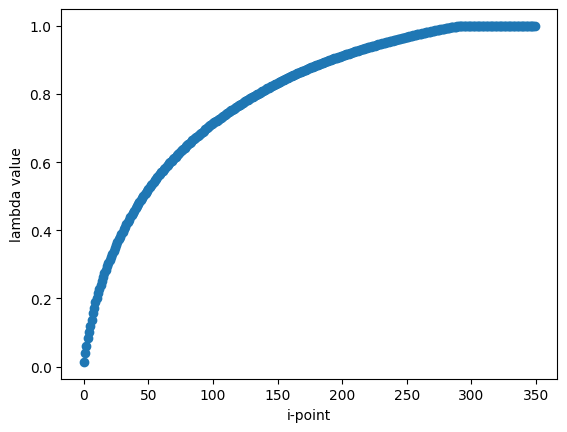

In [ ]:
fig, ax = plt.subplots()
nums = list(range(len(exp_var)))
ax.scatter(nums, cum_exp_var);
ax.set_xlabel('i-point');
ax.set_ylabel('lambda value');

In [ ]:
var_mask = cum_exp_var <= 0.95
sing_values = svd.singular_values_[var_mask]
n_components = sing_values.shape[0]
n_components

233

In [ ]:
svd_with_pc = TruncatedSVD(n_components=n_components)

X_train_tfidf_reduced = svd_with_pc.fit_transform(X_train_tfidf)
X_val_tfidf_reduced = svd_with_pc.transform(X_val_tfidf)

In [ ]:
logreg_tfidf_reduced = LogisticRegression(random_state=42, class_weight='balanced').fit(X_train_tfidf_reduced, y_train)

y_pred_logreg_tfidf_reduced = logreg_tfidf_reduced.predict(X_val_tfidf_reduced)
print(classification_report(y_val, y_pred_logreg_tfidf_reduced))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.81      0.93      0.86        27
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       0.92      0.79      0.85        29
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         8
           7       0.96      1.00      0.98        27
           8       1.00      1.00      1.00        14

    accuracy                           0.94       150
   macro avg       0.97      0.96      0.96       150
weighted avg       0.94      0.94      0.94       150



## Другие модели на TF-IDF

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.05, 0.1, 1., 10.],
    # 'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [100, 200, 300, 500, 700, 100]
}

grid_search_logreg_tfidf_reduced = GridSearchCV(
    LogisticRegression(random_state=42, class_weight='balanced'),
    param_grid, scoring='accuracy', cv=3, verbose=2
    )

grid_search_logreg_tfidf_reduced.fit(X_train_tfidf_reduced, y_train)

best_params_logreg_tfidf_reduced = grid_search_logreg_tfidf_reduced.best_params_
best_model_logreg_tfidf_reduced = grid_search_logreg_tfidf_reduced.best_estimator_

y_pred_logreg_tfidf_reduced = best_model_logreg_tfidf_reduced.predict(X_val_tfidf_reduced)

print("Best Parameters")
print(best_params_logreg_tfidf_reduced)
print("Accuracy with Best Parameters:", classification_report(y_val, y_pred_logreg_tfidf_reduced))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ..............................C=0.001, max_iter=100; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=100; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=100; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=200; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=200; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=200; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=300; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=300; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=300; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=500; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=500; total time=   0.0s
[CV] END ..............................C=0.001,

In [ ]:
svm_tfidf_reduced = SVC(random_state=42, class_weight='balanced').fit(X_train_tfidf_reduced, y_train)

y_pred_svm_tfidf_reduced = svm_tfidf_reduced.predict(X_val_tfidf_reduced)
print(classification_report(y_val, y_pred_svm_tfidf_reduced))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.81      0.93      0.86        27
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       0.92      0.79      0.85        29
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         8
           7       0.96      1.00      0.98        27
           8       1.00      1.00      1.00        14

    accuracy                           0.94       150
   macro avg       0.97      0.96      0.96       150
weighted avg       0.94      0.94      0.94       150



In [ ]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
     'C': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4, 1e5],
    'gamma': [0.1, 1, 10, 100]
}

grid_search_svc_tfidf_reduced = GridSearchCV(
    SVC(random_state=42, class_weight='balanced'),
    param_grid, scoring='accuracy', cv=3, verbose=2
    )

grid_search_svc_tfidf_reduced.fit(X_train_tfidf_reduced, y_train)

best_params_svc_tfidf_reduced = grid_search_svc_tfidf_reduced.best_params_
best_model_svc_tfidf_reduced = grid_search_svc_tfidf_reduced.best_estimator_

y_pred_svc_tfidf_reduced = best_model_svc_tfidf_reduced.predict(X_val_tfidf_reduced)

print("Best Parameters")
print(best_params_svc_tfidf_reduced)
print(classification_report(y_val, y_pred_svc_tfidf_reduced))

Fitting 3 folds for each of 176 candidates, totalling 528 fits
[CV] END ..................C=1e-05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..................C=1e-05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..................C=1e-05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=1e-05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=1e-05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=1e-05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ....................C=1e-05, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....................C=1e-05, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....................C=1e-05, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .................C=1e-05, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .................C=1e-05, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .................C=1e-05, gamma=0.1, 

In [ ]:
tree_tfidf_reduced = DecisionTreeClassifier(random_state=42, class_weight='balanced').fit(X_train_tfidf_reduced, y_train)

y_pred_tree_tfidf_reduced = tree_tfidf_reduced.predict(X_val_tfidf_reduced)
print(classification_report(y_val, y_pred_tree_tfidf_reduced))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.50      0.85      0.63        27
           2       1.00      0.73      0.84        11
           3       1.00      1.00      1.00        12
           4       0.50      0.21      0.29        29
           5       0.70      1.00      0.82         7
           6       0.60      0.38      0.46         8
           7       0.79      0.85      0.82        27
           8       1.00      1.00      1.00        14

    accuracy                           0.71       150
   macro avg       0.76      0.74      0.73       150
weighted avg       0.71      0.71      0.68       150



In [ ]:
forest_tfidf_reduced = RandomForestClassifier(random_state=42, class_weight='balanced').fit(X_train_tfidf_reduced, y_train)

y_pred_forest_tfidf_reduced = forest_tfidf_reduced.predict(X_val_tfidf_reduced)
print(classification_report(y_val, y_pred_forest_tfidf_reduced))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.67      0.89      0.76        27
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       0.85      0.59      0.69        29
           5       1.00      0.86      0.92         7
           6       1.00      0.75      0.86         8
           7       0.82      1.00      0.90        27
           8       1.00      1.00      1.00        14

    accuracy                           0.86       150
   macro avg       0.93      0.88      0.89       150
weighted avg       0.88      0.86      0.86       150



In [ ]:
gb_tfidf_reduced = HistGradientBoostingClassifier(random_state=42).fit(X_train_tfidf_reduced, y_train)

y_pred_gb_tfidf_reduced = gb_tfidf_reduced.predict(X_val_tfidf_reduced)
print(classification_report(y_val, y_pred_gb_tfidf_reduced))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.62      0.96      0.75        27
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       0.85      0.38      0.52        29
           5       0.88      1.00      0.93         7
           6       0.86      0.75      0.80         8
           7       0.90      1.00      0.95        27
           8       1.00      1.00      1.00        14

    accuracy                           0.85       150
   macro avg       0.90      0.88      0.88       150
weighted avg       0.87      0.85      0.83       150



# TF-IDF, предобработанные данные

In [ ]:
train_set_preproc = pd.read_csv('/content/drive/MyDrive/BIV хакатон/preprocessed/train_clean.csv')
train_set_preproc

,id,sum,text,label
0,1,15300,участие конференция address_tag,SERVICE
1,2,40200,оказание услуга,SERVICE
2,3,1440,порошок стиральный ariel color automat amount_tag,NON_FOOD_GOODS
3,4,240000000,возврат денежный средство договор заём no_nds_tag,LOAN
4,5,1360000,сброс загрязнять вещество,NOT_CLASSIFIED
...,...,...,...,...
495,496,2610,налог,TAX
496,497,31200,комиссия выполнение функция агент валютный кон...,BANK_SERVICE
497,498,18200,тур поездка,SERVICE
498,499,2870000,дымовские колбаса yes_nds_tag,FOOD_GOODS


In [ ]:
trg_encoder = LabelEncoder()
train_set_preproc['target'] = trg_encoder.fit_transform(train_set['target'])
train_set_preproc

,id,sum,text,label,target
0,1,15300,участие конференция address_tag,SERVICE,7
1,2,40200,оказание услуга,SERVICE,7
2,3,1440,порошок стиральный ariel color automat amount_tag,NON_FOOD_GOODS,4
3,4,240000000,возврат денежный средство договор заём no_nds_tag,LOAN,3
4,5,1360000,сброс загрязнять вещество,NOT_CLASSIFIED,5
...,...,...,...,...,...
495,496,2610,налог,TAX,8
496,497,31200,комиссия выполнение функция агент валютный кон...,BANK_SERVICE,0
497,498,18200,тур поездка,SERVICE,7
498,499,2870000,дымовские колбаса yes_nds_tag,FOOD_GOODS,1


In [ ]:
X_train_preproc, X_val_preproc, y_train_preproc, y_val_preproc = train_test_split(
    train_set_preproc['text'],
    train_set_preproc['target'],
    test_size=0.3,
    stratify=train_set_preproc['target'],
    random_state=42
)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

X_train_preproc_tfidf = tfidf_vectorizer.fit_transform(X_train_preproc)
X_val_preproc_tfidf = tfidf_vectorizer.transform(X_val_preproc)

In [ ]:
logreg_preproc_tfidf = LogisticRegression(random_state=42, class_weight='balanced').fit(X_train_preproc_tfidf, y_train_preproc)

y_pred_logreg_preproc_tfidf = logreg_preproc_tfidf.predict(X_val_preproc_tfidf)
print(classification_report(y_val_preproc, y_pred_logreg_preproc_tfidf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.95      0.67      0.78        27
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       0.76      0.97      0.85        29
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00        27
           8       1.00      1.00      1.00        14

    accuracy                           0.93       150
   macro avg       0.97      0.96      0.96       150
weighted avg       0.94      0.93      0.93       150



In [ ]:
svm_preproc_tfidf= SVC(random_state=42,
                        class_weight='balanced',
                        C=10, gamma=1, kernel='sigmoid').fit(X_train_preproc_tfidf, y_train_preproc)

y_pred_svm_preproc_tfidf = svm_preproc_tfidf.predict(X_val_preproc_tfidf)
print(classification_report(y_val_preproc, y_pred_svm_preproc_tfidf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.95      0.67      0.78        27
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       0.76      0.97      0.85        29
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00        27
           8       1.00      1.00      1.00        14

    accuracy                           0.93       150
   macro avg       0.97      0.96      0.96       150
weighted avg       0.94      0.93      0.93       150



### PCA

In [ ]:
X_train_preproc_tfidf.shape

(350, 456)

In [ ]:
svd = TruncatedSVD(n_components=456).fit(X_train_preproc_tfidf)
exp_var = svd.explained_variance_ratio_
cum_exp_var = np.cumsum(exp_var)
cum_exp_var

array([0.06046347, 0.09775703, 0.13290549, 0.16918966, 0.19273071,
       0.21572948, 0.23470344, 0.25488621, 0.27542229, 0.29570029,
       0.31522689, 0.3333138 , 0.35066376, 0.36756099, 0.38446603,
       0.39983604, 0.41433636, 0.42863283, 0.44285484, 0.45664676,
       0.46896956, 0.48187126, 0.49425353, 0.50604973, 0.51773153,
       0.52878967, 0.53974887, 0.55047623, 0.56094239, 0.57133515,
       0.58153593, 0.59148814, 0.60105807, 0.61030135, 0.61923011,
       0.62803863, 0.63677536, 0.645482  , 0.65416667, 0.66265634,
       0.6706606 , 0.67833253, 0.68587864, 0.69324875, 0.7001499 ,
       0.70658875, 0.71283745, 0.71883088, 0.72486195, 0.73071251,
       0.73655535, 0.74214804, 0.74770018, 0.75322346, 0.75870584,
       0.76406951, 0.76918984, 0.77420924, 0.77918897, 0.78408658,
       0.78878157, 0.79330256, 0.79767474, 0.80194529, 0.80614474,
       0.81021678, 0.81424863, 0.81818029, 0.82199536, 0.82569353,
       0.82933333, 0.83283893, 0.83631921, 0.83977584, 0.84315

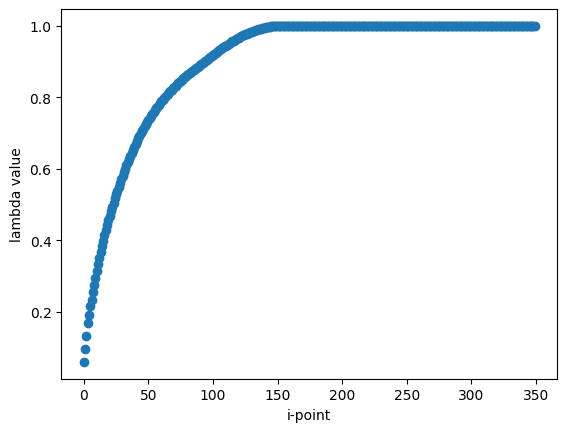

In [ ]:
fig, ax = plt.subplots()
nums = list(range(len(exp_var)))
ax.scatter(nums, cum_exp_var);
ax.set_xlabel('i-point');
ax.set_ylabel('lambda value');

In [ ]:
var_mask = cum_exp_var <= 0.95
sing_values = svd.singular_values_[var_mask]
n_components = sing_values.shape[0]
n_components

113

In [ ]:
svd_with_pc = TruncatedSVD(n_components=n_components)

X_train_preproc_tfidf_reduced = svd_with_pc.fit_transform(X_train_preproc_tfidf)
X_val_preproc_tfidf_reduced = svd_with_pc.transform(X_val_preproc_tfidf)

In [ ]:
logreg_preproc_tfidf_reduced = LogisticRegression(
    random_state=42, class_weight='balanced').fit(X_train_preproc_tfidf_reduced, y_train_preproc)

y_pred_logreg_preproc_tfidf_reduced = logreg_preproc_tfidf_reduced.predict(X_val_preproc_tfidf_reduced)
print(classification_report(y_val_preproc, y_pred_logreg_preproc_tfidf_reduced))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.95      0.67      0.78        27
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       0.76      0.97      0.85        29
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00        27
           8       1.00      1.00      1.00        14

    accuracy                           0.93       150
   macro avg       0.97      0.96      0.96       150
weighted avg       0.94      0.93      0.93       150



## Другие модели на TF-IDF

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.05, 0.1, 1., 10.],
    'max_iter': [100, 200, 300, 500, 700, 100]
}

grid_search_logreg_preproc_tfidf_reduced = GridSearchCV(
    LogisticRegression(random_state=42, class_weight='balanced'),
    param_grid, scoring='accuracy', cv=3, verbose=2
    )

grid_search_logreg_preproc_tfidf_reduced.fit(X_train_preproc_tfidf_reduced, y_train_preproc)

best_params_logreg_preproc_tfidf_reduced = grid_search_logreg_preproc_tfidf_reduced.best_params_
best_model_logreg_preproc_tfidf_reduced = grid_search_logreg_preproc_tfidf_reduced.best_estimator_

y_pred_logreg_preproc_tfidf_reduced = best_model_logreg_preproc_tfidf_reduced.predict(X_val_preproc_tfidf_reduced)

print("Best Parameters")
print(best_params_logreg_preproc_tfidf_reduced)
print(classification_report(y_val_preproc, y_pred_logreg_preproc_tfidf_reduced))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ..............................C=0.001, max_iter=100; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=100; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=100; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=200; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=200; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=200; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=300; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=300; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=300; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=500; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=500; total time=   0.0s
[CV] END ..............................C=0.001,

In [ ]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
     'C': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4, 1e5],
    'gamma': [0.1, 1, 10, 100]
}

grid_search_svc_preproc_tfidf_reduced = GridSearchCV(
    SVC(random_state=42, class_weight='balanced'),
    param_grid, scoring='accuracy', cv=3, verbose=2
    )

grid_search_svc_preproc_tfidf_reduced.fit(X_train_preproc_tfidf_reduced, y_train_preproc)

best_params_svc_preproc_tfidf_reduced = grid_search_svc_preproc_tfidf_reduced.best_params_
best_model_svc_preproc_tfidf_reduced = grid_search_svc_preproc_tfidf_reduced.best_estimator_

y_pred_svc_preproc_tfidf_reduced = best_model_svc_preproc_tfidf_reduced.predict(X_val_preproc_tfidf_reduced)

print("Best Parameters")
print(best_params_svc_preproc_tfidf_reduced)
print(classification_report(y_val, y_pred_svc_preproc_tfidf_reduced))

Fitting 3 folds for each of 176 candidates, totalling 528 fits
[CV] END ..................C=1e-05, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ..................C=1e-05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ..................C=1e-05, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=1e-05, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .....................C=1e-05, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .....................C=1e-05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ....................C=1e-05, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....................C=1e-05, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ....................C=1e-05, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .................C=1e-05, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .................C=1e-05, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .................C=1e-05, gamma=0.1, 

In [ ]:
tree_preproc_tfidf_reduced = DecisionTreeClassifier(
    random_state=42, class_weight='balanced').fit(X_train_preproc_tfidf_reduced, y_train_preproc)

y_pred_tree_preproc_tfidf_reduced = tree_preproc_tfidf_reduced.predict(X_val_preproc_tfidf_reduced)
print(classification_report(y_val_preproc, y_pred_tree_preproc_tfidf_reduced))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      0.78      0.82        27
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       0.73      0.83      0.77        29
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         8
           7       1.00      0.78      0.88        27
           8       0.74      1.00      0.85        14

    accuracy                           0.89       150
   macro avg       0.93      0.93      0.92       150
weighted avg       0.90      0.89      0.89       150



In [ ]:
forest_preproc_tfidf_reduced = RandomForestClassifier(
    random_state=42, class_weight='balanced').fit(X_train_preproc_tfidf_reduced, y_train_preproc)

y_pred_forest_preproc_tfidf_reduced = forest_preproc_tfidf_reduced.predict(X_val_preproc_tfidf_reduced)
print(classification_report(y_val_preproc, y_pred_forest_preproc_tfidf_reduced))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.89      0.63      0.74        27
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       0.78      0.86      0.82        29
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         8
           7       1.00      0.78      0.88        27
           8       0.56      1.00      0.72        14

    accuracy                           0.87       150
   macro avg       0.92      0.92      0.91       150
weighted avg       0.90      0.87      0.87       150



In [ ]:
gb_preproc_tfidf_reduced = HistGradientBoostingClassifier(
    random_state=42).fit(X_train_preproc_tfidf_reduced, y_train_preproc)

y_pred_gb_preproc_tfidf_reduced = gb_preproc_tfidf_reduced.predict(X_val_preproc_tfidf_reduced)
print(classification_report(y_val_preproc, y_pred_gb_preproc_tfidf_reduced))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.89      0.63      0.74        27
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        12
           4       0.78      0.86      0.82        29
           5       1.00      1.00      1.00         7
           6       0.62      1.00      0.76         8
           7       1.00      0.78      0.88        27
           8       0.70      1.00      0.82        14

    accuracy                           0.87       150
   macro avg       0.89      0.92      0.89       150
weighted avg       0.89      0.87      0.87       150



# Разметка основных данных

In [ ]:
train_labeled = train_set['text'].apply(lambda x: x.lower())
labels = train_set['target']

train_unlabeled = pd.read_csv('/content/drive/MyDrive/BIV хакатон/data/payments_main.tsv',
                              delimiter='\t', header=None)
train_unlabeled.columns = ['id', 'date', 'price', 'text']
train_unlabeled = train_unlabeled['text'].apply(lambda x: x.lower())

In [ ]:
train_labeled

,text
0,за участие в конференции в г. майкоп по догово...
1,за оказание услуг по договору №79-02726в от 01...
2,оплата за порошок стиральный ariel color autom...
3,возврат денежных средств по договору займа №04...
4,"оплата дог №452 от 13/03/2021, согл. сч 0745-2..."
...,...
495,оплата налогов
496,комиссия за выполнение функций агента валютног...
497,за тур.поездку по договору №75-04243г от 24/04...
498,"оплата по договору №095 от 24.02.2025г, счету ..."


In [ ]:
train_unlabeled

,text
0,за тур.поездку по договору №001 от 27.01.2023г
1,за оказание услуг по договору №53б-02746 от 23...
2,оплата штрафа
3,лечение по договору №д-00359/24 от 08.03.2025
4,оплата основного долга за период с 16.12.2024г...
...,...
24995,оплата по договору №е01905 от 25.02.2023. сырь...
24996,гос.услуга
24997,предоставление кредита по договору №д-00803/03...
24998,оплата гос. пошлины


In [ ]:
labels

,target
0,7
1,7
2,4
3,3
4,5
...,...
495,8
496,0
497,7
498,1


In [ ]:
labels_dict = dict(zip(trg_encoder.classes_, trg_encoder.transform(trg_encoder.classes_)))
labels_dict

{'BANK_SERVICE': 0,
 'FOOD_GOODS': 1,
 'LEASING': 2,
 'LOAN': 3,
 'NON_FOOD_GOODS': 4,
 'NOT_CLASSIFIED': 5,
 'REALE_STATE': 6,
 'SERVICE': 7,
 'TAX': 8}

In [ ]:
inverse_labels_dict = dict(zip(labels_dict.values(), labels_dict.keys()))
inverse_labels_dict

{0: 'BANK_SERVICE',
 1: 'FOOD_GOODS',
 2: 'LEASING',
 3: 'LOAN',
 4: 'NON_FOOD_GOODS',
 5: 'NOT_CLASSIFIED',
 6: 'REALE_STATE',
 7: 'SERVICE',
 8: 'TAX'}

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

train_labeled_tfidf = tfidf_vectorizer.fit_transform(train_labeled)
train_unlabeled_tfidf = tfidf_vectorizer.transform(train_unlabeled)

In [ ]:
train_labeled_tfidf.shape

(500, 1499)

In [ ]:
svd = TruncatedSVD(n_components=1499).fit(train_labeled_tfidf)
exp_var = svd.explained_variance_ratio_
cum_exp_var = np.cumsum(exp_var)
cum_exp_var

array([0.01279928, 0.03754077, 0.05888654, 0.08031933, 0.09932265,
       0.11778503, 0.13448623, 0.14970985, 0.16422534, 0.17832101,
       0.19190359, 0.2051268 , 0.21816474, 0.23057478, 0.24242501,
       0.25347966, 0.26435267, 0.27469311, 0.28486292, 0.29413127,
       0.30295104, 0.31167372, 0.32003249, 0.32799144, 0.33587258,
       0.34360054, 0.35100052, 0.3583291 , 0.36545715, 0.37243332,
       0.37924482, 0.38592998, 0.39250041, 0.39890605, 0.40527818,
       0.41137781, 0.4174489 , 0.42333893, 0.42917174, 0.43487255,
       0.4405058 , 0.44594979, 0.45130237, 0.4565792 , 0.4617561 ,
       0.46687091, 0.47190069, 0.47686701, 0.48177892, 0.48661191,
       0.4913694 , 0.49607713, 0.50068319, 0.5052407 , 0.50976802,
       0.51429203, 0.51875793, 0.52312953, 0.52747611, 0.53177409,
       0.53597844, 0.54013977, 0.54426606, 0.54825838, 0.55220855,
       0.55613365, 0.55998505, 0.56381085, 0.56754998, 0.57118356,
       0.57480822, 0.5783905 , 0.58192312, 0.58536766, 0.58879

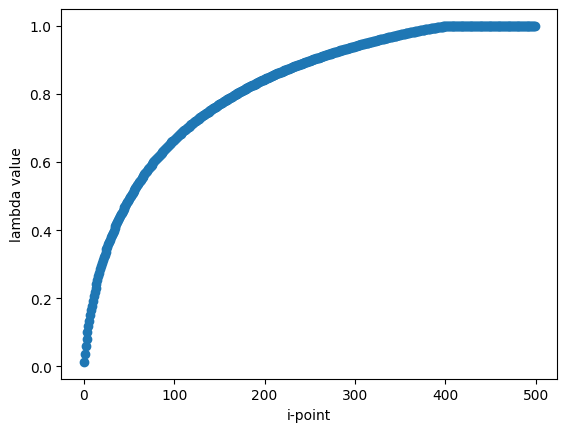

In [ ]:
fig, ax = plt.subplots()
nums = list(range(len(exp_var)))
ax.scatter(nums, cum_exp_var);
ax.set_xlabel('i-point');
ax.set_ylabel('lambda value');

In [ ]:
var_mask = cum_exp_var <= 0.95
sing_values = svd.singular_values_[var_mask]
n_components = sing_values.shape[0]
n_components

314

In [ ]:
svd_with_pc = TruncatedSVD(n_components=n_components)

train_labeled_tfidf_reduced = svd_with_pc.fit_transform(train_labeled_tfidf)
train_unlabeled_tfidf_reduced = svd_with_pc.transform(train_unlabeled_tfidf)

In [ ]:
whole_train = np.concatenate((train_labeled_tfidf_reduced, train_unlabeled_tfidf_reduced))
whole_train.shape

(25500, 314)

In [ ]:
whole_labels = np.concatenate((labels, np.array([-1]*25000)))
whole_labels.shape

(25500,)

In [ ]:
self_training = SelfTrainingClassifier(
    SVC(random_state=42, class_weight='balanced',
        C=10, gamma=1, kernel='sigmoid', probability=True)
)

self_training.fit(whole_train, whole_labels)

SelfTrainingClassifier(base_estimator=SVC(C=10, class_weight='balanced',
                                          gamma=1, kernel='sigmoid',
                                          probability=True, random_state=42))

In [ ]:
predicted_labels = self_training.predict(train_unlabeled_tfidf_reduced)

In [ ]:
predicted_labels

array([7, 7, 8, ..., 0, 8, 1])

In [ ]:
predicted_labels.shape

(25000,)

In [ ]:
from collections import Counter
Counter(predicted_labels)

Counter({7: 3844,
         8: 2005,
         0: 1610,
         1: 6050,
         5: 1319,
         4: 5640,
         2: 1780,
         3: 2005,
         6: 747})

In [ ]:
map_labels = np.vectorize(lambda x: inverse_labels_dict[x])

mapped_pred_labels = map_labels(predicted_labels)
mapped_labels = map_labels(labels)
mapped_pred_labels

array(['SERVICE', 'SERVICE', 'TAX', ..., 'BANK_SERVICE', 'TAX',
       'FOOD_GOODS'], dtype='<U14')

In [ ]:
final_df = pd.DataFrame(
    {
        'text': np.concatenate((train_labeled, train_unlabeled)),
        'labels': np.concatenate((mapped_labels, mapped_pred_labels))
    }
)
final_df

,text,labels
0,за участие в конференции в г. майкоп по догово...,SERVICE
1,за оказание услуг по договору №79-02726в от 01...,SERVICE
2,оплата за порошок стиральный ariel color autom...,NON_FOOD_GOODS
3,возврат денежных средств по договору займа №04...,LOAN
4,"оплата дог №452 от 13/03/2021, согл. сч 0745-2...",NOT_CLASSIFIED
...,...,...
25495,оплата по договору №е01905 от 25.02.2023. сырь...,NON_FOOD_GOODS
25496,гос.услуга,TAX
25497,предоставление кредита по договору №д-00803/03...,BANK_SERVICE
25498,оплата гос. пошлины,TAX


In [ ]:
final_df.to_csv('labeled_main.csv')

In [ ]:
train_set_preproc = pd.read_csv('/content/drive/MyDrive/BIV хакатон/preprocessed/train_clean.csv')
train_set_preproc

,id,sum,text,label
0,1,15300,участие конференция address_tag,SERVICE
1,2,40200,оказание услуга,SERVICE
2,3,1440,порошок стиральный ariel color automat amount_tag,NON_FOOD_GOODS
3,4,240000000,возврат денежный средство договор заём no_nds_tag,LOAN
4,5,1360000,сброс загрязнять вещество,NOT_CLASSIFIED
...,...,...,...,...
495,496,2610,налог,TAX
496,497,31200,комиссия выполнение функция агент валютный кон...,BANK_SERVICE
497,498,18200,тур поездка,SERVICE
498,499,2870000,дымовские колбаса yes_nds_tag,FOOD_GOODS


In [ ]:
train_set_preproc_unlab = pd.read_csv('/content/drive/MyDrive/BIV хакатон/preprocessed/main_clean.csv')
train_set_preproc_unlab

,id,sum,text
0,1,40500,тур поездка
1,2,32600,оказание услуга
2,3,4710,штраф
3,4,30900,лечение
4,5,13200,основный долг период оао второй банк
...,...,...,...
24995,24996,3300000,сырье пвад yes_nds_tag
24996,24997,2270,гос услуга
24997,24998,1750000,предоставление кредит приобретение недвижимость
24998,24999,3560,гос пошлина


In [ ]:
final_df_preproc = pd.DataFrame(
    {
        'text': np.concatenate((train_set_preproc['text'], train_set_preproc_unlab['text'])),
        'labels': np.concatenate((train_set_preproc['label'], mapped_pred_labels))
    }
)
final_df_preproc

,text,labels
0,участие конференция address_tag,SERVICE
1,оказание услуга,SERVICE
2,порошок стиральный ariel color automat amount_tag,NON_FOOD_GOODS
3,возврат денежный средство договор заём no_nds_tag,LOAN
4,сброс загрязнять вещество,NOT_CLASSIFIED
...,...,...
25495,сырье пвад yes_nds_tag,NON_FOOD_GOODS
25496,гос услуга,TAX
25497,предоставление кредит приобретение недвижимость,BANK_SERVICE
25498,гос пошлина,TAX


In [ ]:
final_df_preproc.to_csv('labeled_main_clean.csv')